In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [2]:
adata = sc.read_10x_mtx('./VTA_seq/filtered_feature_bc_matrix/', cache=True)

... reading from cache file cache/VTA_seq-filtered_feature_bc_matrix-matrix.h5ad


In [4]:
adata

AnnData object with n_obs × n_vars = 16532 × 32285
    var: 'gene_ids', 'feature_types'

In [3]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito']= np.sum(adata[:,mito_genes].X,axis = 1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

filtered out 7879 genes that are detected in less than 3 cells


In [6]:
adata

AnnData object with n_obs × n_vars = 16532 × 24406
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

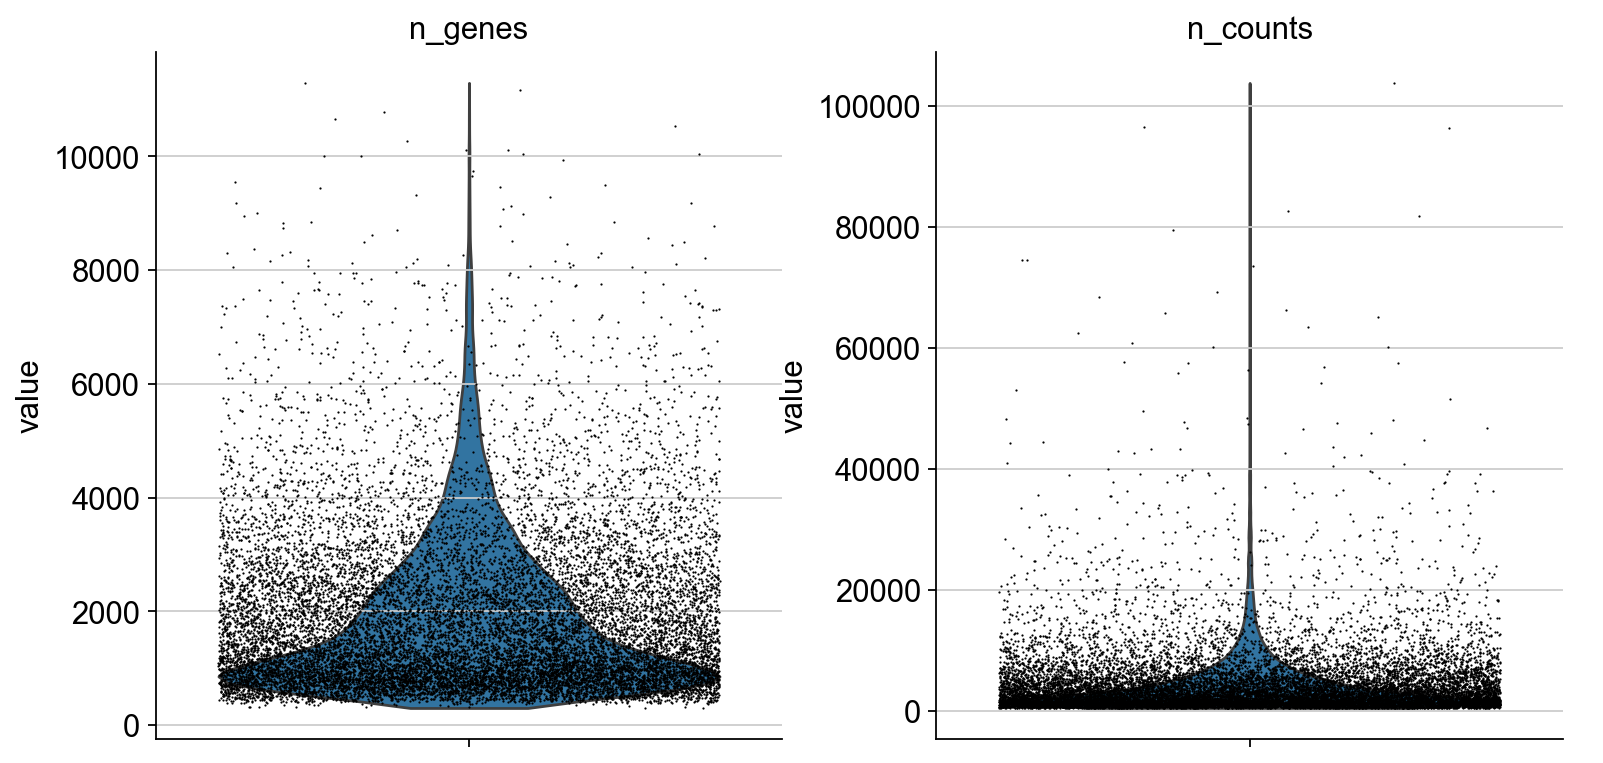

In [7]:
sc.pl.violin(
    adata,
    ["n_genes", "n_counts"],
    jitter=0.4,
    multi_panel=True,
)

In [4]:
adata = adata[adata.obs.n_genes< 8000, :]
adata = adata[adata.obs.n_counts < 15000, :]
adata = adata[adata.obs.percent_mito < 0.01, :]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 15880 × 24406
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

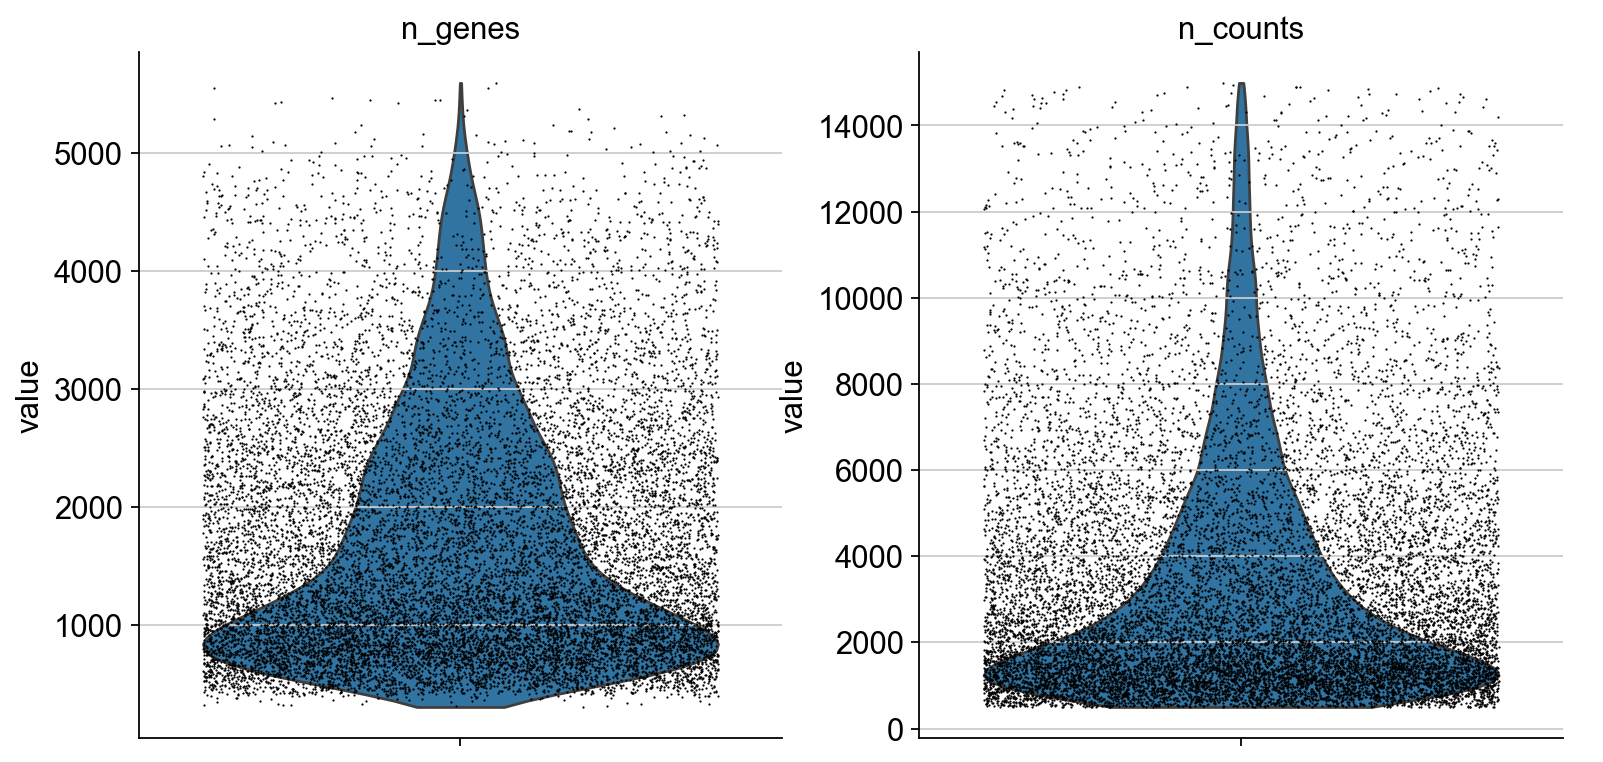

In [10]:
sc.pl.violin(
    adata,
    ["n_genes", "n_counts"],
    jitter=0.4,
    multi_panel=True,
)

In [11]:
sc.external.pp.scrublet(adata, sim_doublet_ratio=2.0, expected_doublet_rate=0.05, stdev_doublet_rate=0.02)

Running Scrublet


/Users/gaoxiang/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


filtered out 507 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/gaoxiang/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_scrublet/__init__.py:286: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]


    Scrublet finished (0:00:47)


In [12]:
adata.layers["counts"] = adata.X.copy()

In [5]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell


/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:553: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [14]:
adata.raw = adata

In [6]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5,flavor='seurat')
sc.set_figure_params(color_map='RdBu_r')
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50


/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:01)


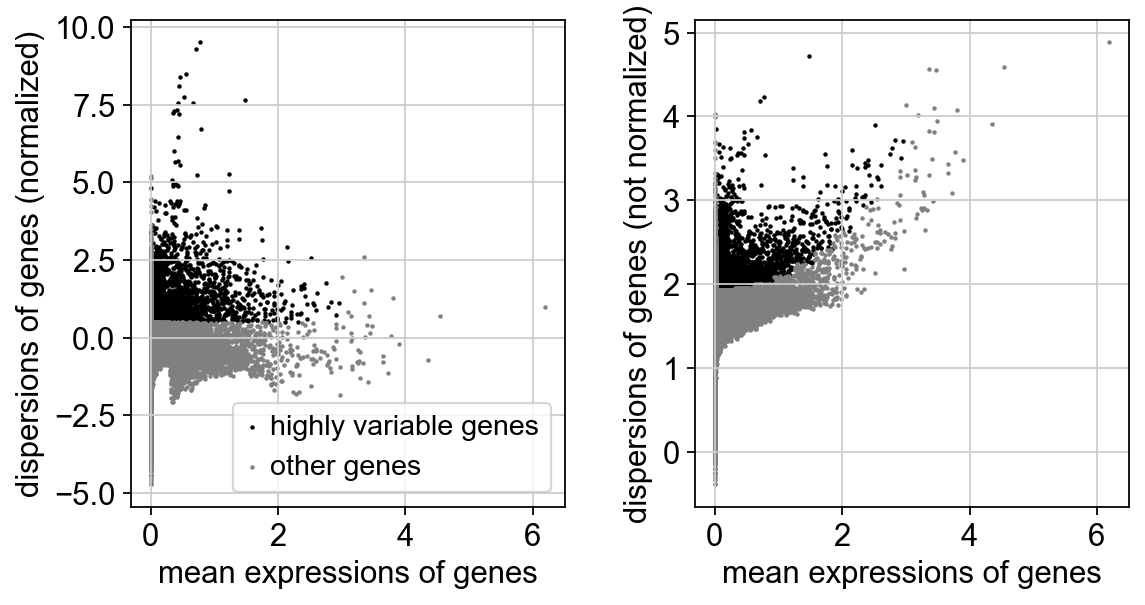

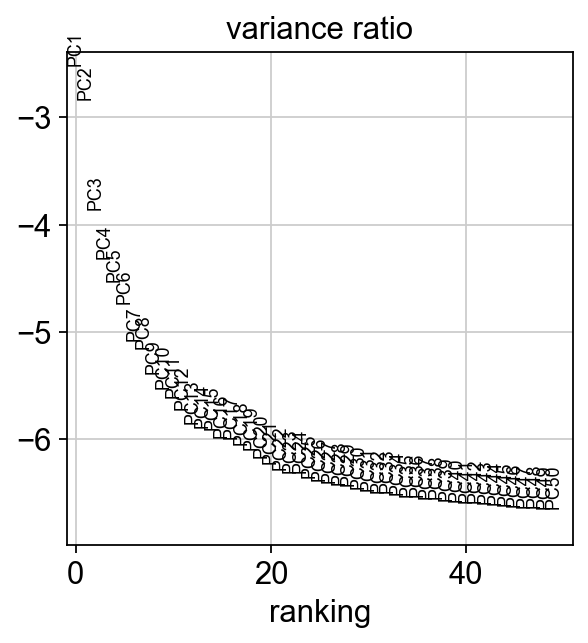

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [7]:
sc.pl.highly_variable_genes(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X_pca')
sc.tl.umap(adata)


In [8]:
adata_f=sc.read_h5ad('VTA_2_filter.h5ad')

In [9]:
doublet = []
for i in range(adata.shape[0]):
    if adata.obs.index[i] in adata_f.obs.index:
        doublet.append('False')
    else: 
        doublet.append('True')
adata.obs['VTA_2_Doublet'] = doublet

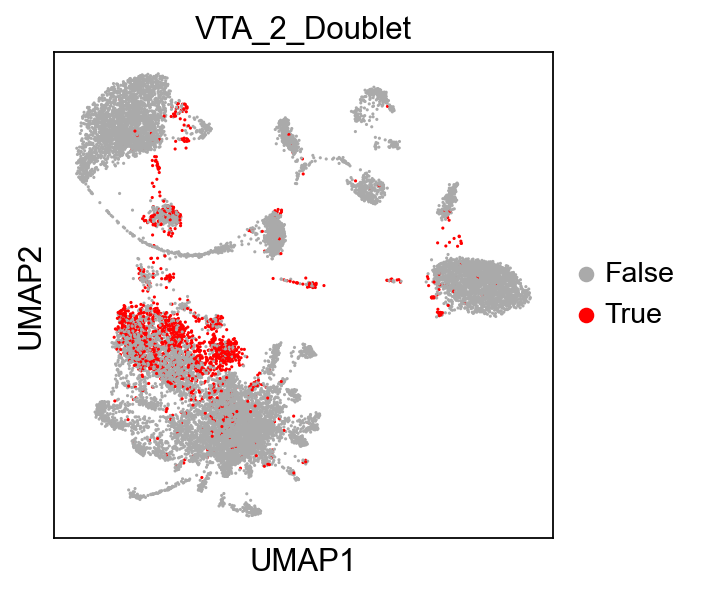

In [10]:
sc.pl.umap(
    adata,
    color="VTA_2_Doublet",
    # increase horizontal space between panels
    wspace=0.5,
    size=8,palette=['#aaaaaa','red'],save='VTA_2_doublet.pdf'
)

/Users/gaoxiang/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function scrublet_score_distribution is deprecated; Import from sc.pl instead
  warnings.warn(msg, category=FutureWarning)


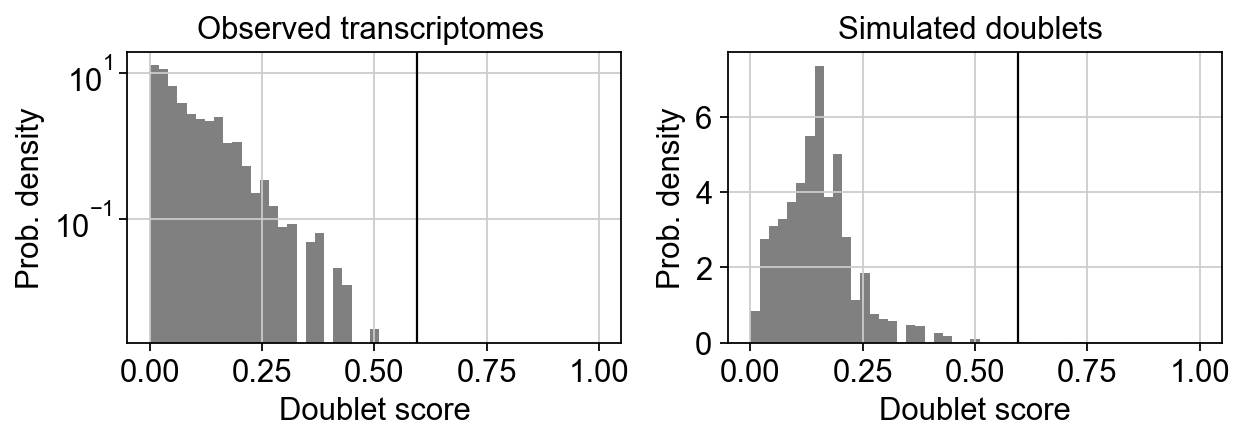

In [35]:
sc.external.pl.scrublet_score_distribution(adata, scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3))

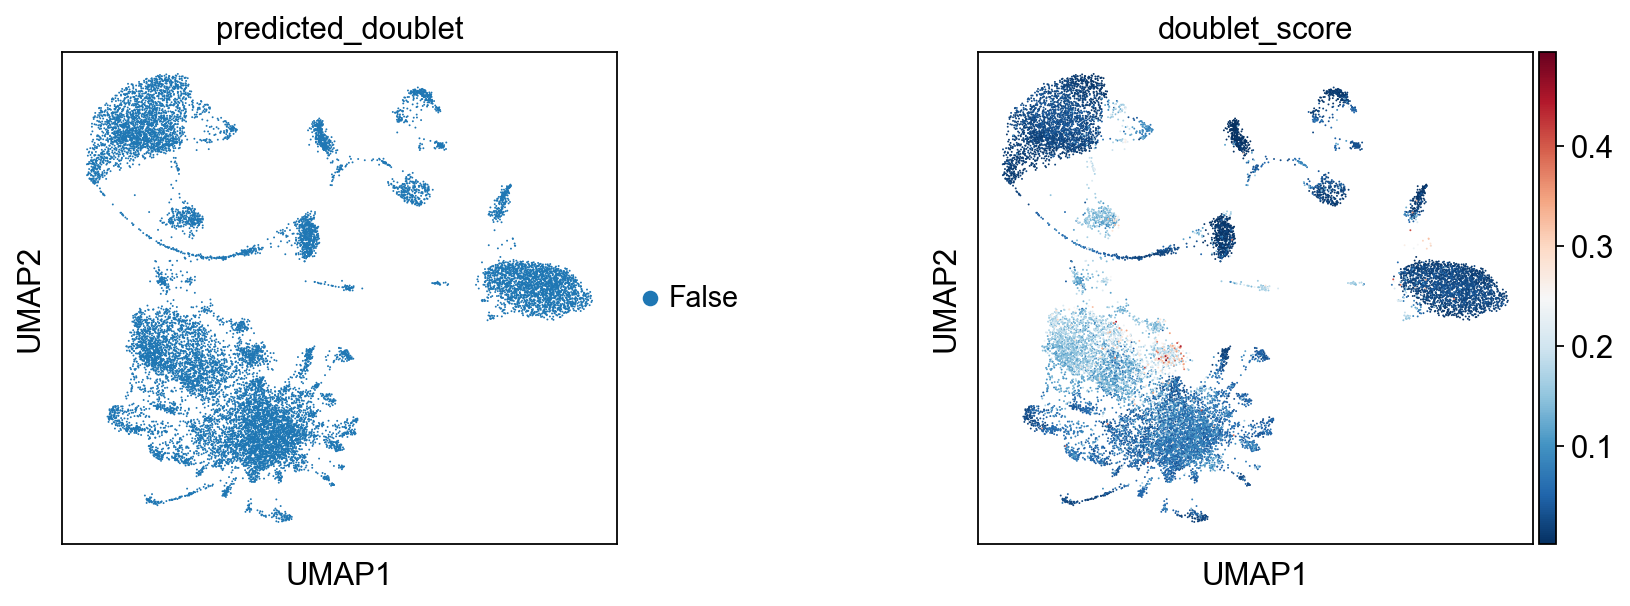

In [18]:
sc.pl.umap(
    adata,
    color=["predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

In [19]:
test = adata[adata.obs['doublet_score'] < 0.3,:]

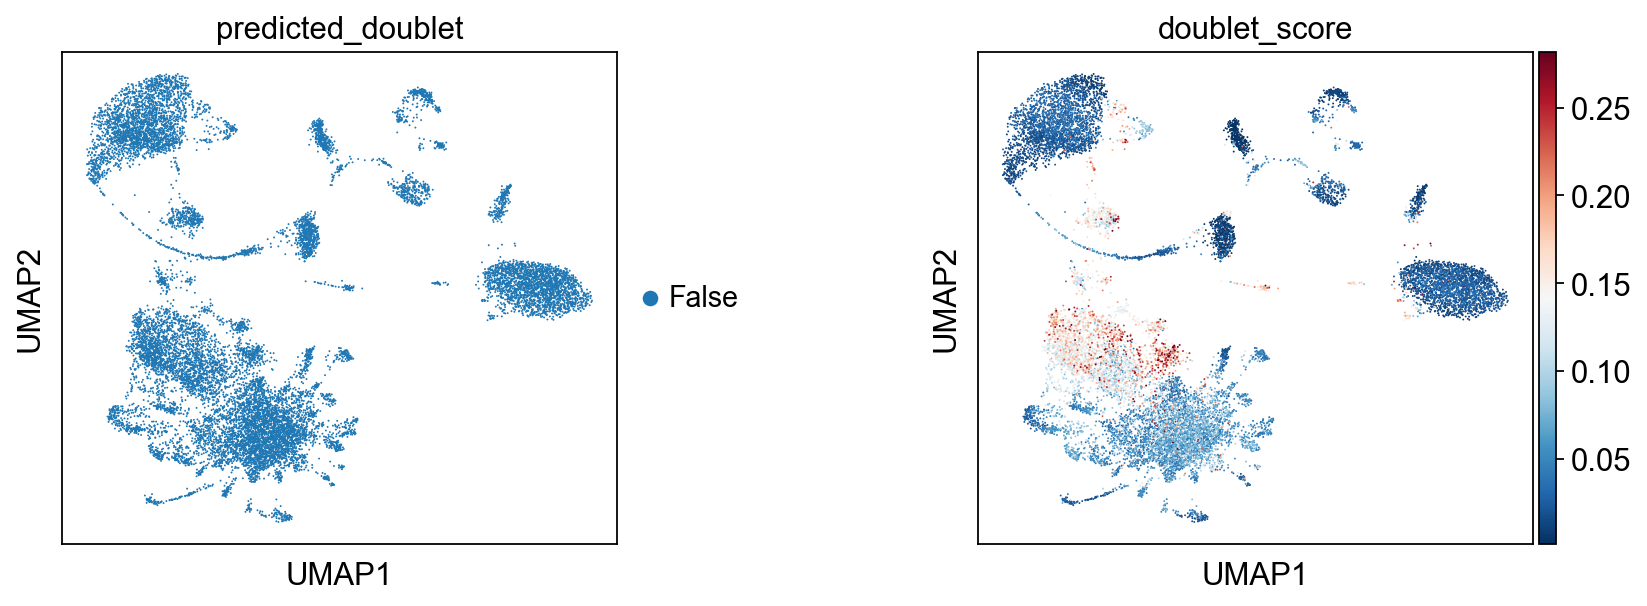

In [20]:
sc.pl.umap(
    test,
    color=["predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

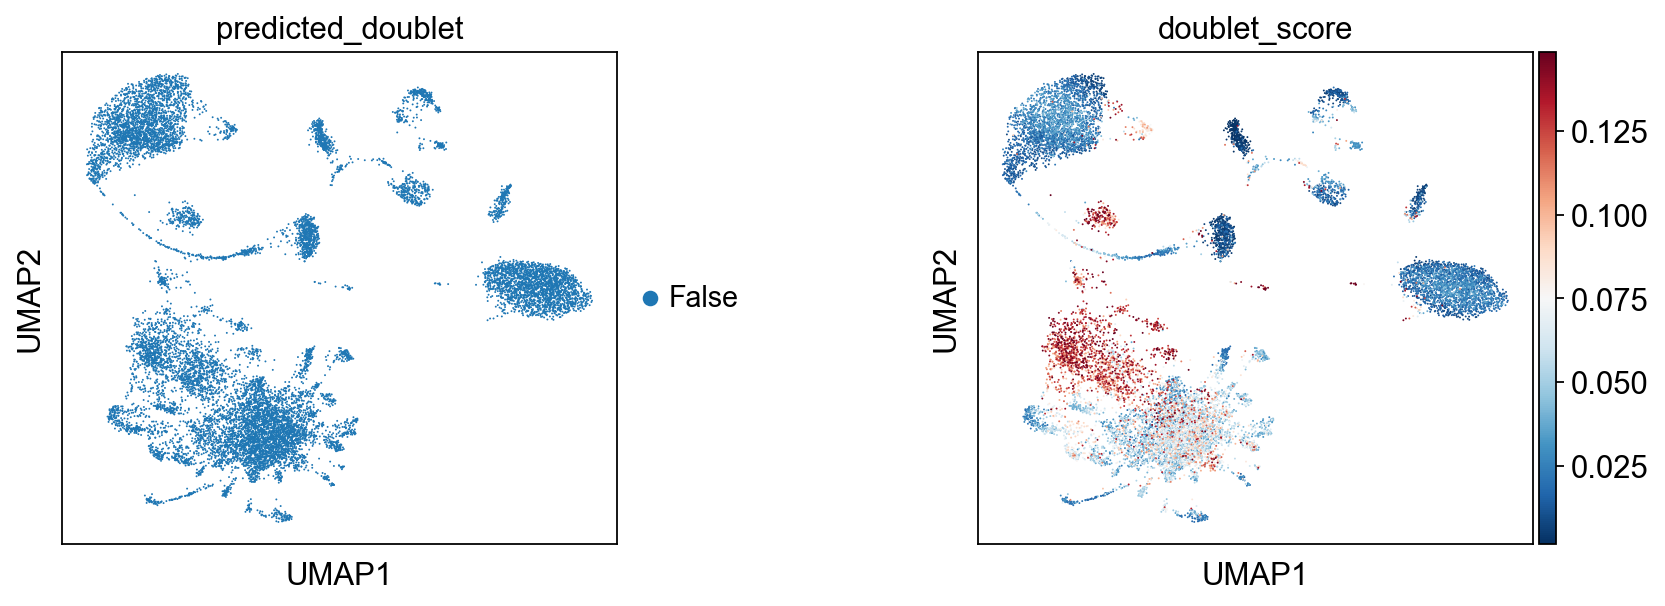

In [21]:
test = adata[adata.obs['doublet_score'] < 0.15,:]
sc.pl.umap(
    test,
    color=["predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

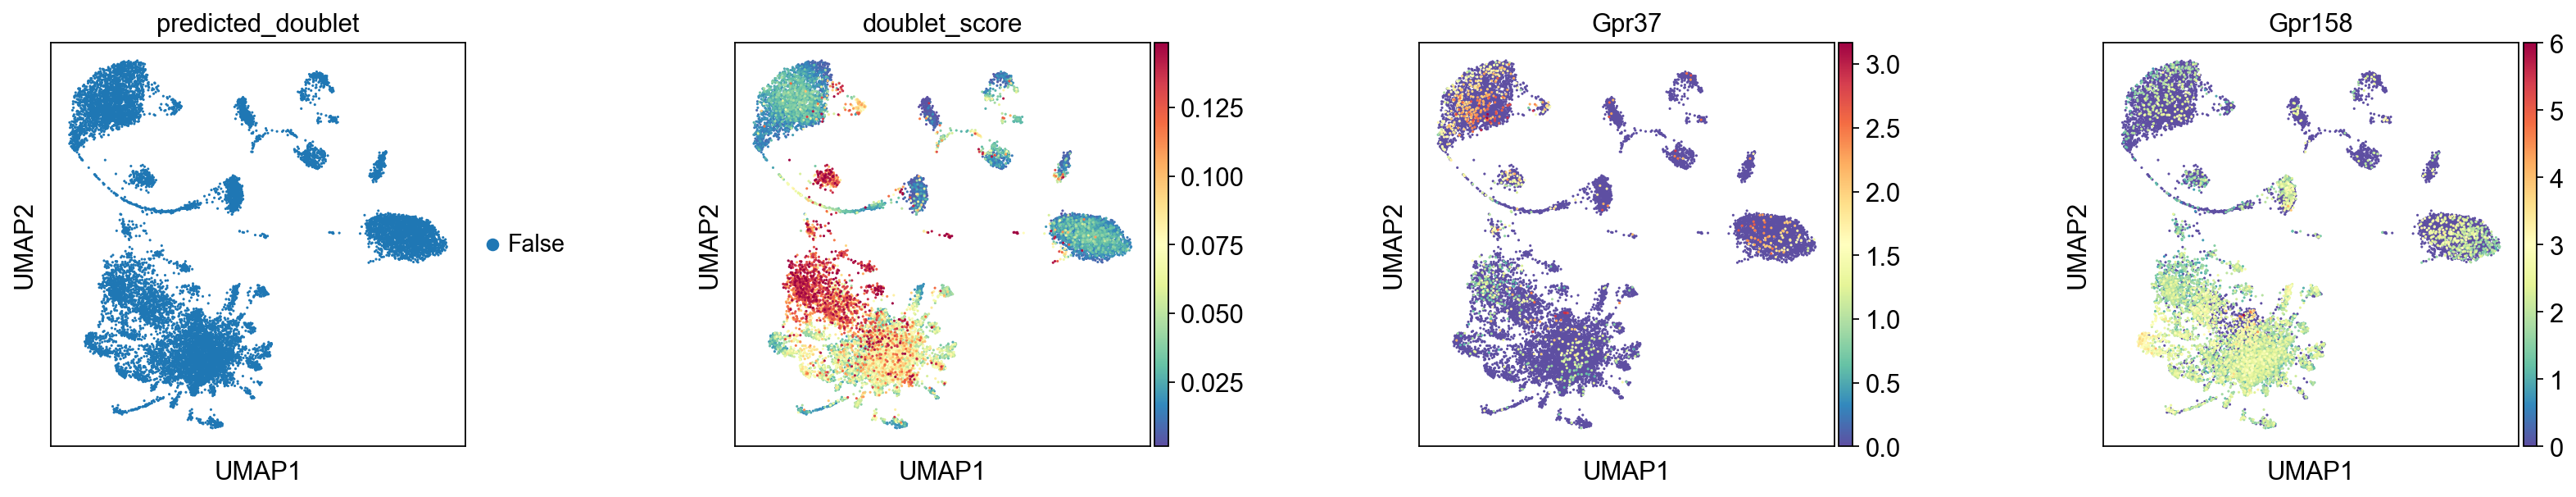

In [29]:
sc.pl.umap(
    test,
    color=["predicted_doublet", "doublet_score","Gpr37","Gpr158"],
    # increase horizontal space between panels
    wspace=0.5,cmap='Spectral_r',
    size=8,
)

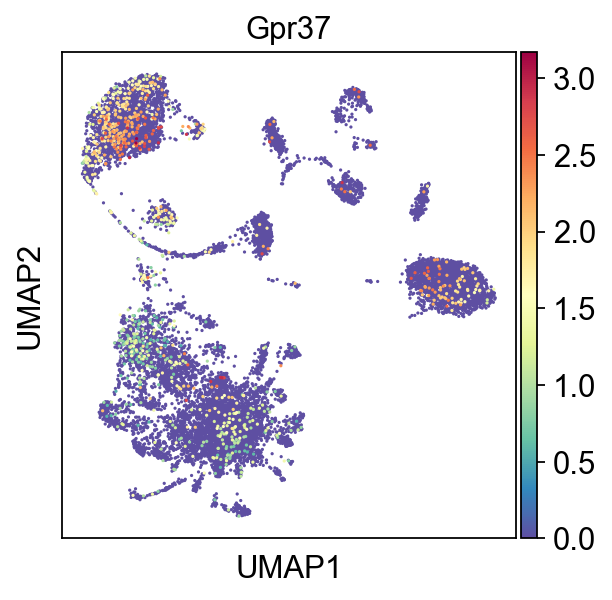

In [31]:
sc.pl.umap(test, color='Gpr37',cmap='Spectral_r')

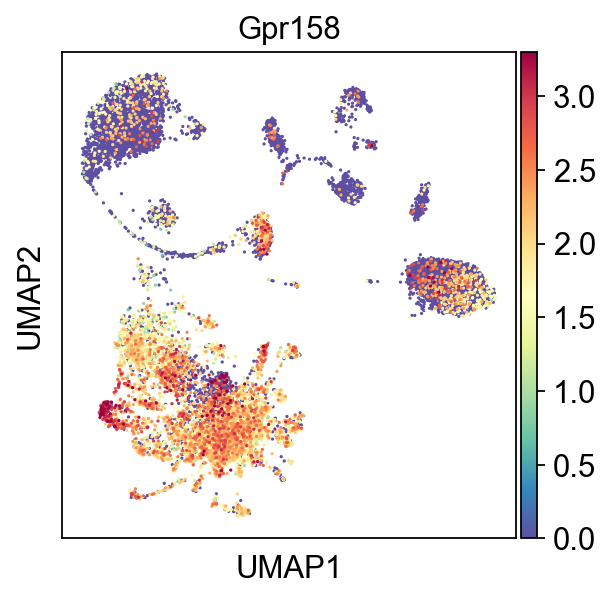

In [34]:
sc.pl.umap(test, color='Gpr158',cmap='Spectral_r',vmax = 3.3)

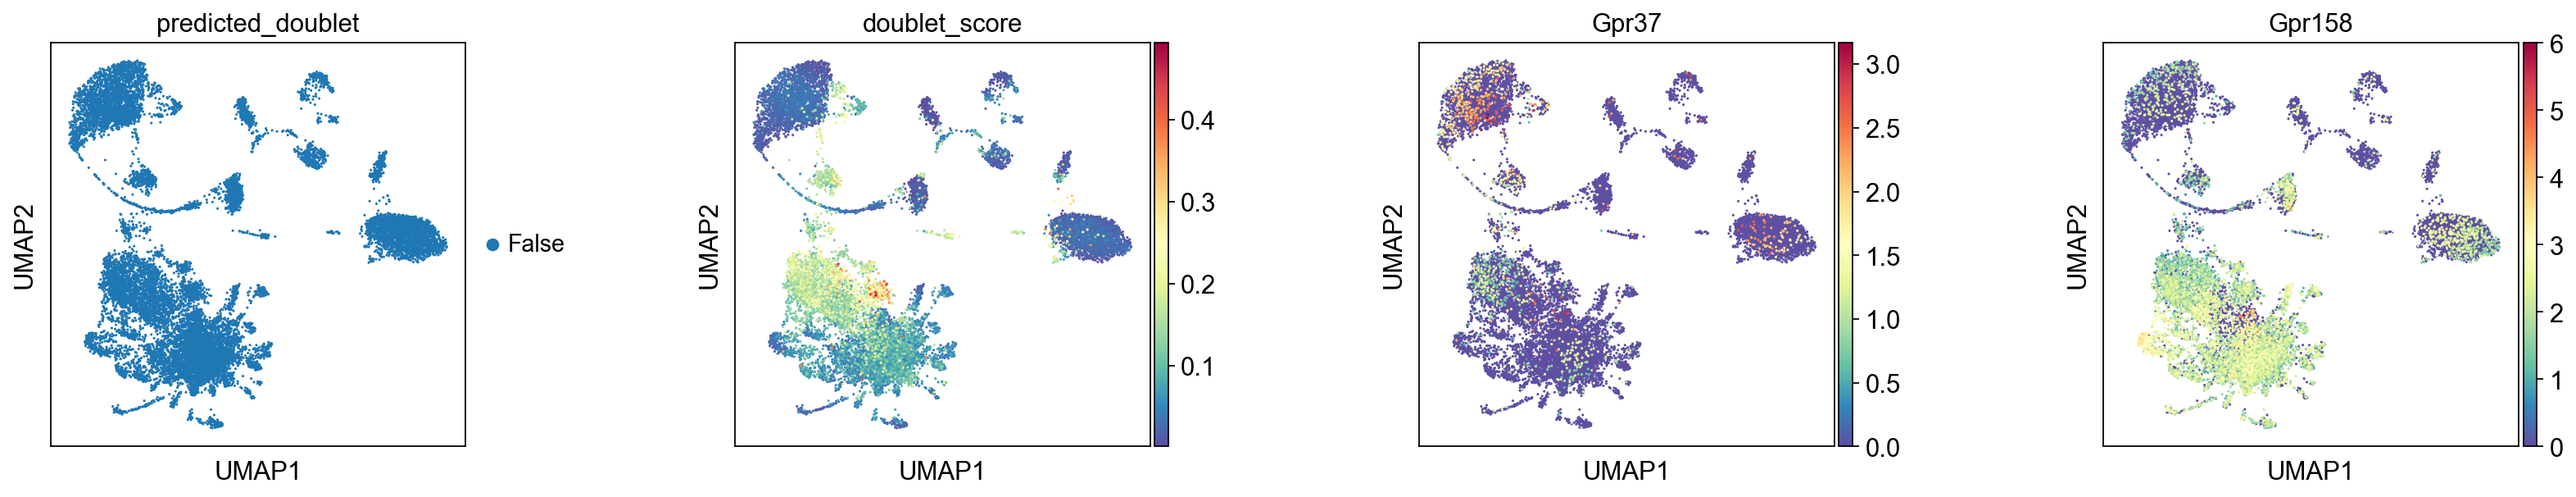

In [30]:
sc.pl.umap(
    adata,
    color=["predicted_doublet", "doublet_score","Gpr37","Gpr158"],
    # increase horizontal space between panels
    wspace=0.5,cmap='Spectral_r',
    size=8,
)

In [36]:
test.write('VTA_2_filter.h5ad')

In [37]:
for res in [0.5,0.8,1,1.2,1.5]:
    sc.tl.leiden(
        test, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

running Leiden clustering


/Users/gaoxiang/anaconda3/lib/python3.11/site-packages/scanpy/tools/_leiden.py:199: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


    finished: found 24 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 32 clusters and added
    'leiden_res_0.80', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 34 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 37 clusters and added
    'leiden_res_1.20', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 42 clusters and added
    'leiden_res_1.50', the cluster labels (adata.obs, categorical) (0:00:00)


In [42]:
test

AnnData object with n_obs × n_vars = 14230 × 24406
    obs: 'n_genes', 'percent_mito', 'n_counts', 'doublet_score', 'predicted_doublet', 'leiden_res_0.50', 'leiden_res_0.80', 'leiden_res_1.00', 'leiden_res_1.20', 'leiden_res_1.50'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'predicted_doublet_colors', 'leiden_res_0.50', 'leiden_res_0.80', 'leiden_res_1.00', 'leiden_res_1.20', 'leiden_res_1.50', 'leiden_res_0.50_colors', 'leiden_res_0.80_colors', 'leiden_res_1.00_colors', 'leiden_res_1.20_colors', 'leiden_res_1.50_colors', 'dendrogram_leiden_res_0.50', 'dendrogram_leiden_res_0.80', 'dendrogram_leiden_res_1.00'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

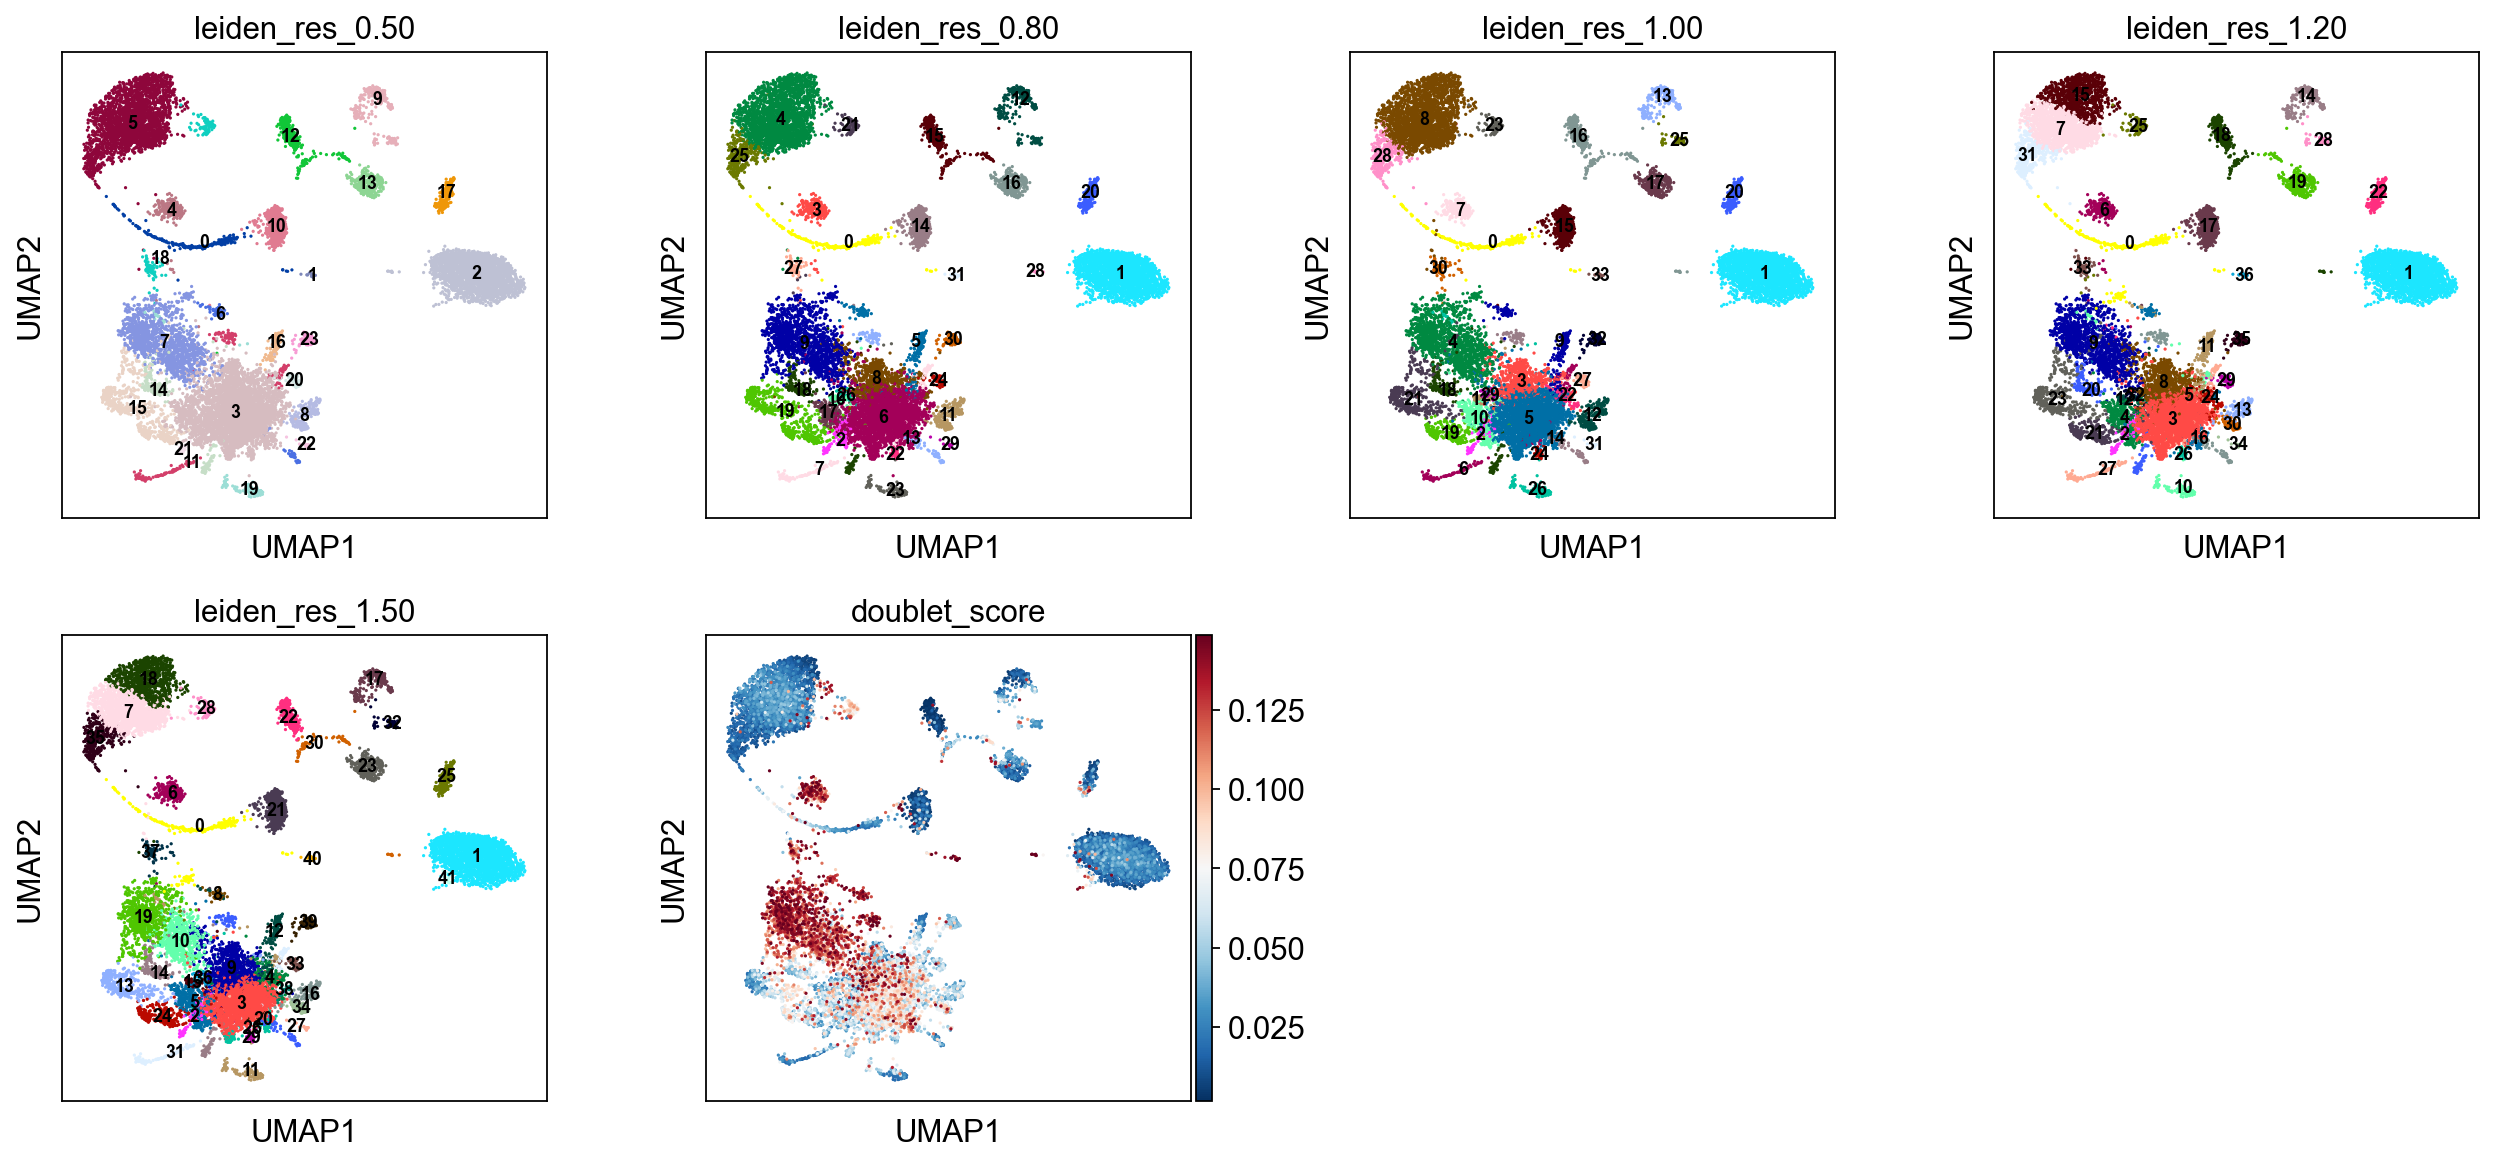

In [43]:
sc.pl.umap(
    test,
    color=["leiden_res_0.50", "leiden_res_0.80","leiden_res_1.00","leiden_res_1.20","leiden_res_1.50","doublet_score"],
    legend_loc="on data",legend_fontsize=8
)

In [39]:
marker_gene = ['Slc17a6','Slc17a7','Slc17a8','Snap25','Slc32a1','Slc18a2','Gad1','Gad2','Aldh1a1','Th','Ddc']

In [40]:
for res in [0.5,0.8,1]:
    sc.tl.dendrogram(test, groupby=f"leiden_res_{res:4.2f}")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_0.50']`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_0.80']`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_1.00']`


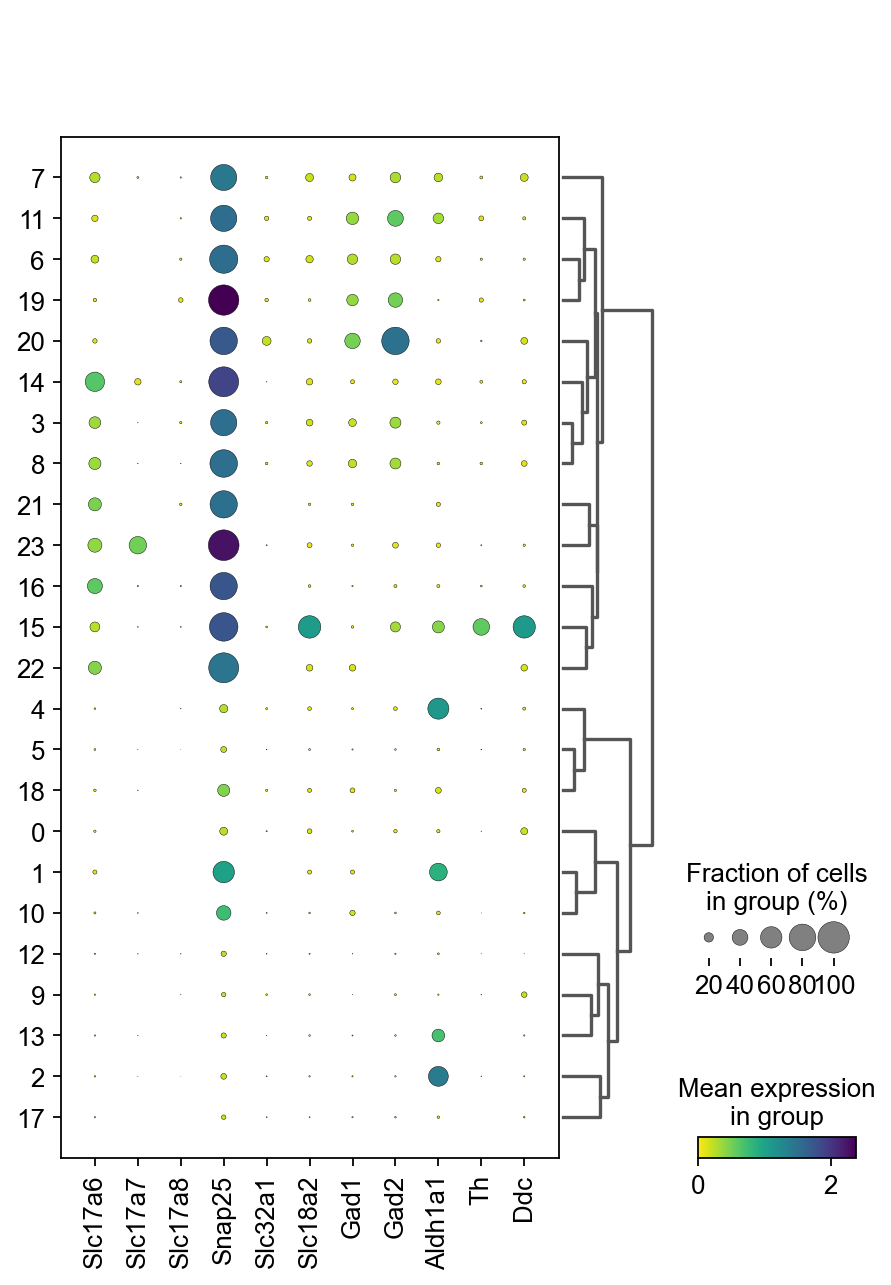

In [44]:
sc.pl.dotplot(test, marker_gene,groupby=["leiden_res_0.50"],cmap='viridis_r',dendrogram=True)

In [45]:
Neuron = []
for i in range(test.shape[0]):
    if (int(test.obs['leiden_res_0.50'][i]) in (17,2,13,9,12,10,0,18,5,4)): 
        Neuron.append('Non-neuron')
    elif (int(test.obs['leiden_res_0.50'][i]) in (1,4)): 
        Neuron.append('Doublet')
    else: 
        Neuron.append('Neuron')
test.obs['Neuron'] = Neuron

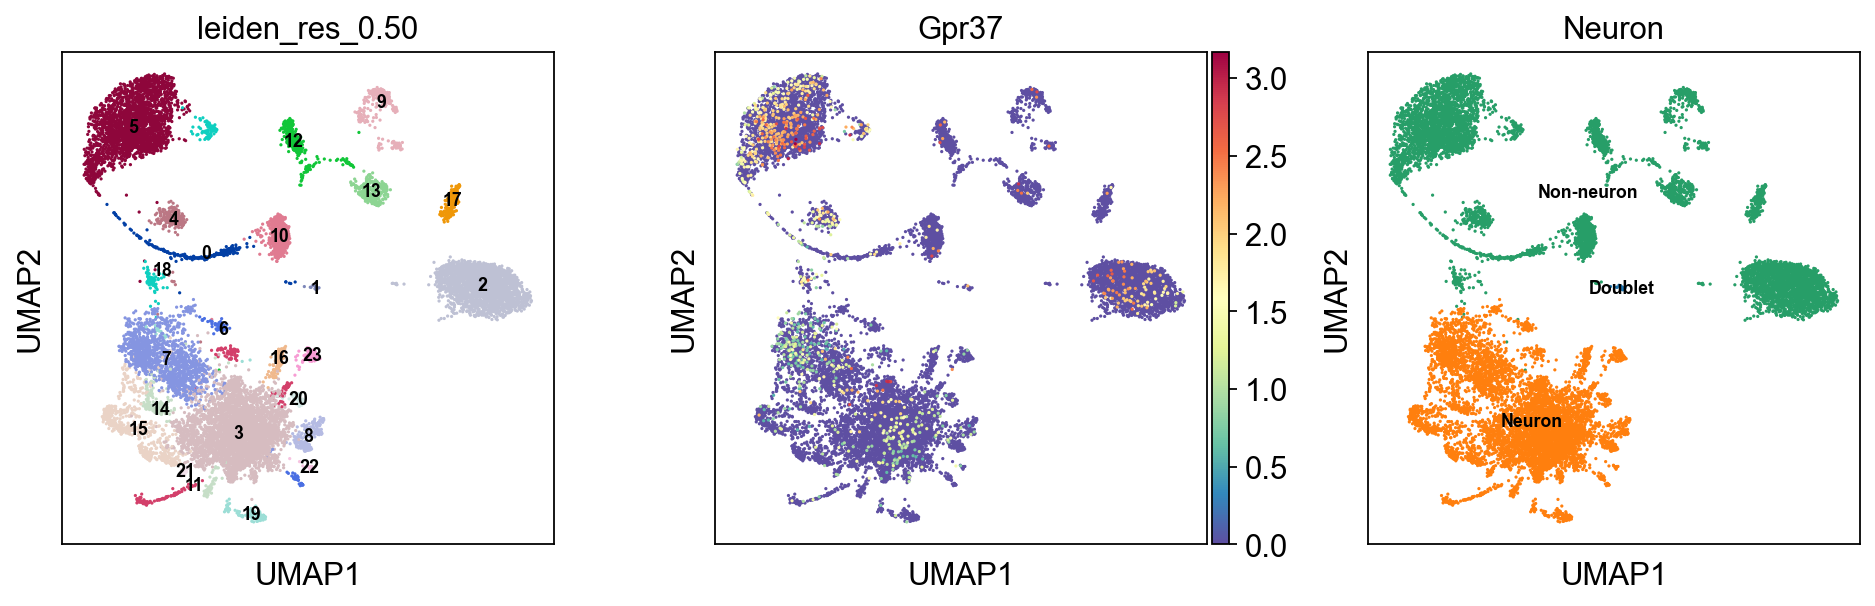

In [48]:
sc.pl.umap(
    test,
    color=["leiden_res_0.50", "Gpr37","Neuron"],
    legend_loc="on data",legend_fontsize=8,cmap='Spectral_r'
)

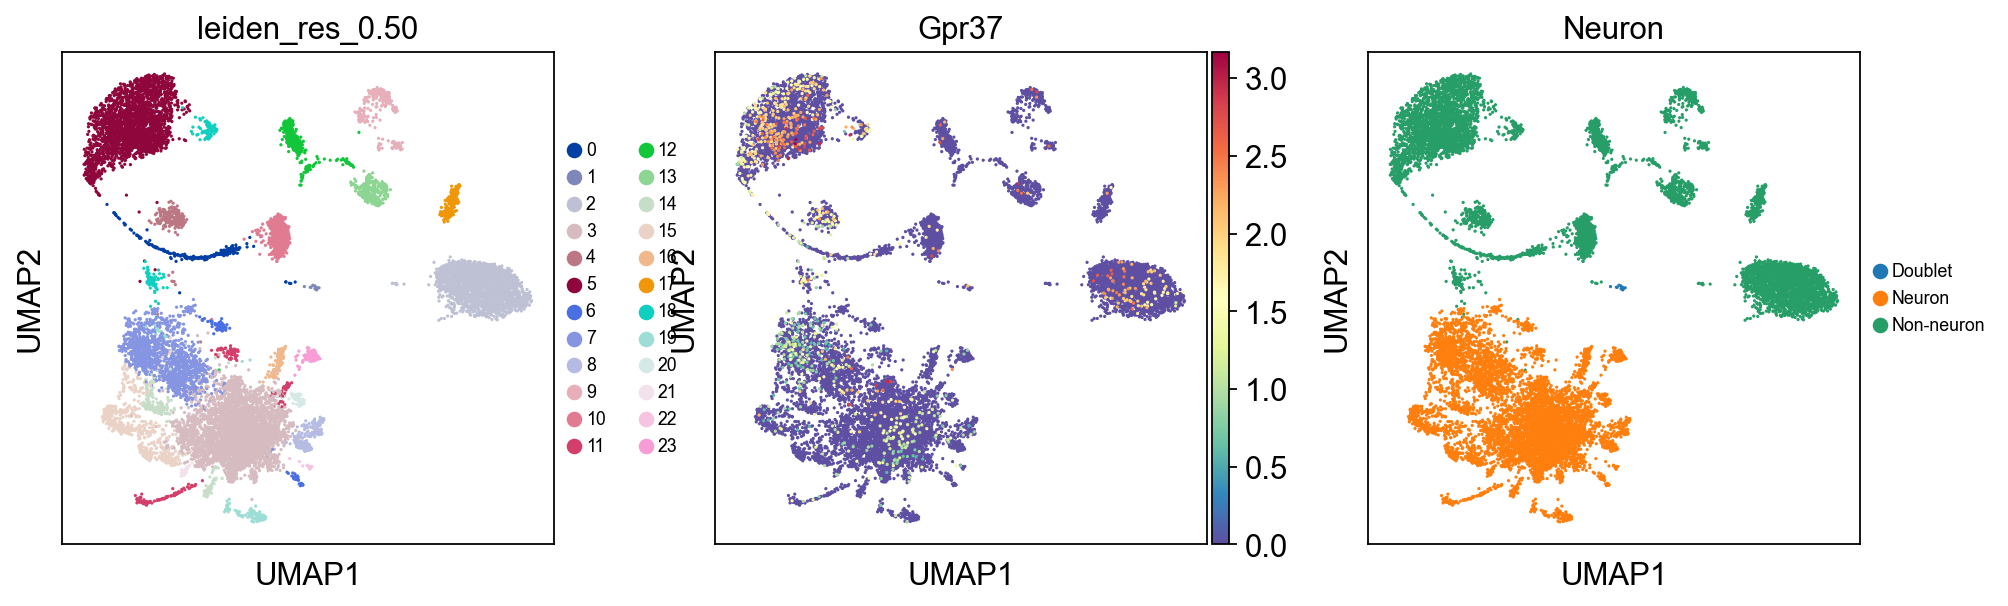

In [49]:
sc.pl.umap(
    test,
    color=["leiden_res_0.50", "Gpr37","Neuron"],
    legend_fontsize=8,cmap='Spectral_r'
)

In [50]:
test.write('VTA_2_clustering_ann.h5ad')

In [51]:
neuron = test[test.obs['Neuron'] == 'Neuron',:]

In [52]:
neuron.write('VTA_2_neuron.h5ad')

In [4]:
adata = sc.read_h5ad('VTA_2_clustering_ann.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 14230 × 24406
    obs: 'n_genes', 'percent_mito', 'n_counts', 'doublet_score', 'predicted_doublet', 'leiden_res_0.50', 'leiden_res_0.80', 'leiden_res_1.00', 'leiden_res_1.20', 'leiden_res_1.50', 'Neuron'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Neuron_colors', 'dendrogram_leiden_res_0.50', 'dendrogram_leiden_res_0.80', 'dendrogram_leiden_res_1.00', 'hvg', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_0.80', 'leiden_res_0.80_colors', 'leiden_res_1.00', 'leiden_res_1.00_colors', 'leiden_res_1.20', 'leiden_res_1.20_colors', 'leiden_res_1.50', 'leiden_res_1.50_colors', 'log1p', 'neighbors', 'pca', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'